In [ ]:
'''
Mount Drive
To search for decoder.py in mounted drive, set path
Install tensorflow-model-optimization
'''
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append('####') # Add path

Mounted at /content/drive


In [ ]:
import numpy as np
import pickle as pk
from decoder import *
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
import tensorflow as tf

import os
import tempfile
import time
from PIL import Image
import requests
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')

In [ ]:
'''
Define folderpath for further operations
'''
FOLDERPATH = '####' # Add path

In [ ]:
# generate a description for an image
def generate_desc_interpreter(interpreter, tokenizer, photo, maxlength, inp_ind, out_ind):
    in_text = 'startseq'
    for i in range(maxlength):
      sequence = tokenizer.texts_to_sequences([in_text])[0]
      sequence = pad_sequences([sequence], maxlen=maxlength)
      photo = photo.astype(np.float32)
      sequence = sequence.astype(np.float32)
      # import pdb; pdb.set_trace()
      interpreter.set_tensor(inp_ind[0],photo)
      interpreter.set_tensor(inp_ind[1],sequence)
      interpreter.invoke()
      output = interpreter.tensor(out_ind)
      yhat = output()[0]
      yhat = argmax(yhat)
      word = word_for_id(yhat, tokenizer)
      if word is None:
        break
      in_text += ' ' + word
      if word == 'endseq':
        break
    return in_text

def captions_interpreter(extractor,interpreter,img_url=None):
  # load data
  tokenizer = load(open(FOLDERPATH+'dataset/tokenizer.pkl', 'rb'))
  maxlength = 34
  input_index = []
  if interpreter.get_input_details()[0]['shape'][1] == 34:
    input_index.append(interpreter.get_input_details()[1]["index"])
    input_index.append(interpreter.get_input_details()[0]["index"])
  else:
    input_index.append(interpreter.get_input_details()[0]["index"])
    input_index.append(interpreter.get_input_details()[1]["index"])
  output_index = interpreter.get_output_details()[0]["index"]

  examplesfolder = FOLDERPATH+'dataset/examples/'
  if not img_url:
    images = os.listdir(examplesfolder)
    url_=False
  else:
    images = [img_url]
    url_=True
  for example in images:
    tf.keras.backend.clear_session()
    if not img_url:
      example = examplesfolder+example
      plt_image = plt.imread(example)
    else:
      example = img_url
      response = requests.get(example)
      plt_image = Image.open(BytesIO(response.content))
    
    if isinstance(extractor,tf.lite.Interpreter):
      extract_func = extract_features_quantized
      ts = tuple(extractor.get_input_details()[0]['shape'][1:3])
    else:
      extract_func = extract_features
      ts = extractor.input_shape[1:3]
    
    start = time.time()
    photo = extract_func(extractor,example,url_,ts)
    description = generate_desc_interpreter(interpreter, tokenizer, photo, maxlength, input_index, output_index)
    new_time = time.time() - start
    plt.imshow(plt_image)
    plt.axis('off')
    plt.show()
    print('\n Description: ',description[9:-7])
    print(' Time taken: ',new_time)

def captions(extractor,model,img_url=None):
  # load data
  tokenizer = load(open(FOLDERPATH+'dataset/tokenizer.pkl', 'rb'))
  maxlength = 34

  examplesfolder = FOLDERPATH+'dataset/examples/'
  if not img_url:
    images = os.listdir(examplesfolder)
    url_=False
  else:
    images = [img_url]
    url_=True
  for example in images:
    tf.keras.backend.clear_session()
    if not img_url:
      example = examplesfolder+example
      plt_image = plt.imread(example)
    else:
      example = img_url
      response = requests.get(example)
      plt_image = Image.open(BytesIO(response.content))
    if isinstance(extractor,tf.lite.Interpreter):
      extract_func = extract_features_quantized
      ts = tuple(extractor.get_input_details()[0]['shape'][1:3])
    else:
      extract_func = extract_features
      ts = extractor.input_shape[1:3]
      
    start = time.time()
    photo = extract_func(extractor,example,url_,ts)
    description = generate_desc(model, tokenizer, photo, maxlength)
    new_time = time.time() - start
    plt.imshow(plt_image)
    plt.axis('off')
    plt.show()
    print('\n Description: ',description[9:-7])
    print(' Time taken: ',new_time)

##### BASELINE VGG16 AND BASELINE LSTM -- Reported

In [ ]:
modelname = 'baseline-VGG16-baseline-LSTM.h5'
model = load_model(FOLDERPATH+'models-v2/baselines/'+modelname)
model.compile(optimizer='adam', loss='categorical_crossentropy')
extractor = VGG16()
# captions(model)

553467904/553467096 [==============================] - 21s 0us/step


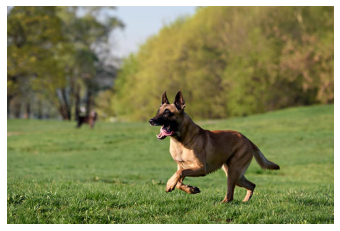


 Description:  two dogs are playing together in the grass
 Time taken:  6.099014520645142


In [ ]:
url = 'https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/06/05231748/belgian-malinois-running-through-field.jpg'
captions(extractor,model,url)

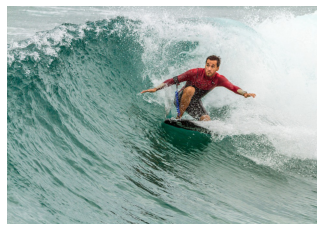


 Description:  man in red shirt is walking through the water
 Time taken:  1.5029237270355225


In [ ]:
url = 'https://static.everypixel.com/ep-pixabay/1461/4477/9123/62691/14614477912362691457-surfing.jpg'
captions(extractor,model,url)

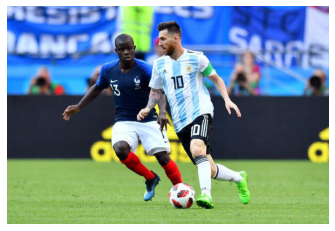


 Description:  two men are playing soccer on the grass
 Time taken:  0.6785485744476318


In [ ]:
url = 'https://static01.nyt.com/images/2020/09/25/sports/25soccer-nationalWEB1/merlin_177451008_91c7b66d-3c8a-4963-896e-54280f374b6d-articleLarge.jpg?quality=75&auto=webp&disable=upscale'
captions(extractor,model,url)

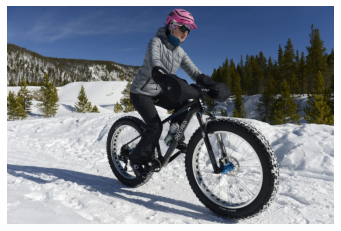


 Description:  man in red shirt is riding bike on dirt path
 Time taken:  0.8533482551574707


In [ ]:
url = 'https://theknow.denverpost.com/wp-content/uploads/2018/11/TR25SNOWBIKE_AC18503x.jpg'
captions(extractor,model,url)

##### BASELINE VGG16 AND QUANTIZED LSTM

In [ ]:
modelname = 'baseline-VGG16-quantized-LSTM'
converter = tf.lite.TFLiteConverter.from_saved_model(FOLDERPATH+'models-v2/quant-aware-training/'+modelname)
tflite_model = converter.convert()
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
extractor = VGG16()

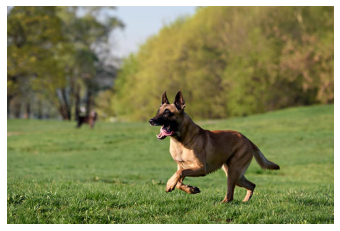


 Description:  two dogs are running on the grass
 Time taken:  0.8332281112670898


In [ ]:
url = 'https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/06/05231748/belgian-malinois-running-through-field.jpg'
captions_interpreter(extractor,interpreter,url)

##### BASELINE RESNET50 AND BASELINE LSTM

In [ ]:
modelname = 'baseline-ResNet-baseline-LSTM.h5'
model = load_model(FOLDERPATH+'models-v2/baselines/'+modelname)
model.compile(optimizer='adam', loss='categorical_crossentropy')
extractor = ResNet50()
# captions(model)

102973440/102967424 [==============================] - 5s 0us/step


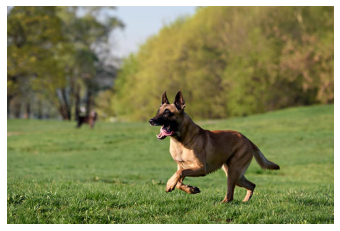


 Description:  two dogs are playing in the grass
 Time taken:  1.6971006393432617


In [ ]:
url = 'https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/06/05231748/belgian-malinois-running-through-field.jpg'
captions(extractor,model,url)

##### BASELINE RESNET50 AND QUANTIZED LSTM

In [ ]:
modelname = 'baseline-ResNet-quantized-LSTM'
converter = tf.lite.TFLiteConverter.from_saved_model(FOLDERPATH+'models-v2/quant-aware-training/'+modelname)
tflite_model = converter.convert()
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
extractor = ResNet50()

102973440/102967424 [==============================] - 2s 0us/step


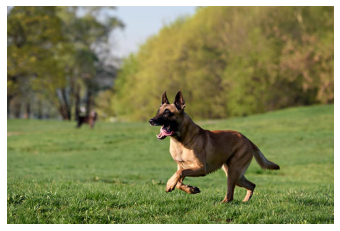


 Description:  dog is running through the grass
 Time taken:  1.4898838996887207


In [ ]:
url = 'https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/06/05231748/belgian-malinois-running-through-field.jpg'
captions_interpreter(extractor,interpreter,url)

##### QUANTIZED VGG16 AND BASELINE LSTM

In [ ]:
modelname = 'quantized-VGG16-baseline-LSTM.h5'
model = load_model(FOLDERPATH+'models-v2/baselines/'+modelname)
model.compile(optimizer='adam', loss='categorical_crossentropy')
encodername = 'quantized-VGG16.tflite'
extractor = tf.lite.Interpreter(model_path=FOLDERPATH+'models-v2/encoders/'+encodername)
extractor.allocate_tensors()

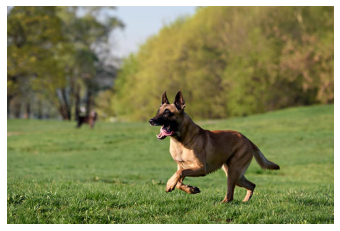


 Description:  dog is running through field
 Time taken:  1.9421932697296143


In [ ]:
url = 'https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/06/05231748/belgian-malinois-running-through-field.jpg'
captions(extractor,model,url)

##### QUANTIZED VGG16 AND QUANTIZED LSTM -- Reported

In [ ]:
modelname = 'quantized-VGG16-quantized-LSTM'
converter = tf.lite.TFLiteConverter.from_saved_model(FOLDERPATH+'models-v2/quant-aware-training/'+modelname)
tflite_model = converter.convert()
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

encodername = 'quantized-VGG16.tflite'
extractor = tf.lite.Interpreter(model_path=FOLDERPATH+'models-v2/encoders/'+encodername)
extractor.allocate_tensors()

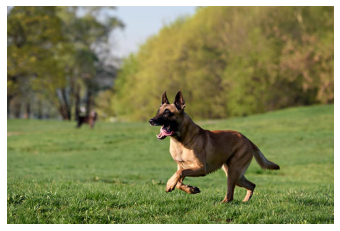


 Description:  dog is running through the grass
 Time taken:  2.8755149841308594


In [ ]:
url = 'https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/06/05231748/belgian-malinois-running-through-field.jpg'
captions_interpreter(extractor,interpreter,url)

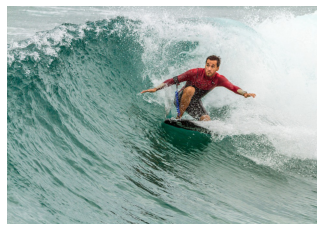


 Description:  the man is in the water
 Time taken:  2.1167101860046387


In [ ]:
url = 'https://static.everypixel.com/ep-pixabay/1461/4477/9123/62691/14614477912362691457-surfing.jpg'
captions_interpreter(extractor,interpreter,url)

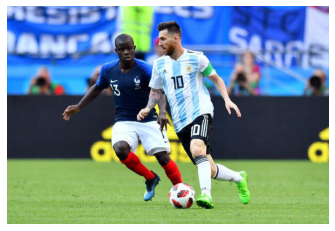


 Description:  two men are playing soccer
 Time taken:  1.3355283737182617


In [ ]:
url = 'https://static01.nyt.com/images/2020/09/25/sports/25soccer-nationalWEB1/merlin_177451008_91c7b66d-3c8a-4963-896e-54280f374b6d-articleLarge.jpg?quality=75&auto=webp&disable=upscale'
captions_interpreter(extractor,interpreter,url)

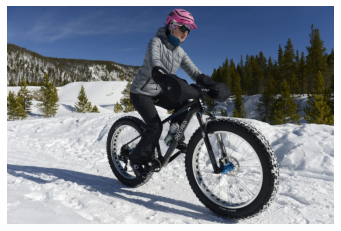


 Description:  man in red shirt is riding bike on dirt path
 Time taken:  1.4476025104522705


In [ ]:
url = 'https://theknow.denverpost.com/wp-content/uploads/2018/11/TR25SNOWBIKE_AC18503x.jpg'
captions_interpreter(extractor,interpreter,url)

##### PRUNED50 VGG16 AND BASELINE LSTM

In [ ]:
modelname = 'pruned50-VGG16-baseline-LSTM_ep_10.h5'
model = load_model(FOLDERPATH+'models-v2/baselines/'+modelname)
model.compile(optimizer='adam', loss='categorical_crossentropy')
extractorname = 'pruned50-VGG16.h5'
extractor = load_model(FOLDERPATH+'models-v2/encoders/'+extractorname)
# captions(model)

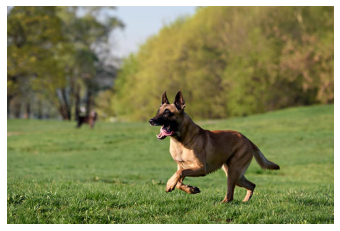


 Description:  two dogs are running through the grass
 Time taken:  1.0053346157073975


In [ ]:
url = 'https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/06/05231748/belgian-malinois-running-through-field.jpg'
captions(extractor,model,url)

##### PRUNED50 VGG16 QUANTIZED LSTM

In [ ]:
modelname = 'pruned50-VGG16-quantized-LSTM'
converter = tf.lite.TFLiteConverter.from_saved_model(FOLDERPATH+'models-v2/quant-aware-training/'+modelname)
tflite_model = converter.convert()
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
extractorname = 'pruned50-VGG16.h5'
extractor = load_model(FOLDERPATH+'models-v2/encoders/'+extractorname)
# captions(model)

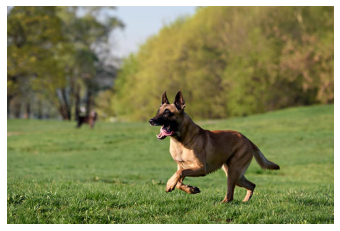


 Description:  man in red shirt is standing on the beach
 Time taken:  0.766211748123169


In [ ]:
url = 'https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/06/05231748/belgian-malinois-running-through-field.jpg'
captions_interpreter(extractor,interpreter,url)

##### PRUNED50QUANT VGG16 QUANTIZED LSTM

In [ ]:
modelname = 'pruned50quant-VGG16-quantized-LSTM_ep_10'
converter = tf.lite.TFLiteConverter.from_saved_model(FOLDERPATH+'models-v2/quant-aware-training/'+modelname)
tflite_model = converter.convert()
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

encodername = 'pruned50quant-VGG16.tflite'
extractor = tf.lite.Interpreter(model_path=FOLDERPATH+'models-v2/encoders/'+encodername)
extractor.allocate_tensors()
# captions(model)

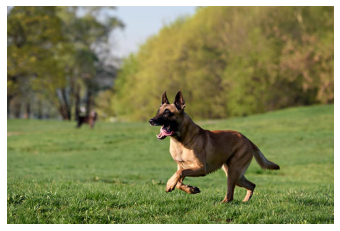


 Description:  man in black shirt is standing on the beach
 Time taken:  0.6739761829376221


In [ ]:
url = 'https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/06/05231748/belgian-malinois-running-through-field.jpg'
captions_interpreter(extractor,interpreter,url)

##### ROUGH